### Let's Start

##### **Loading Data & Importing Libraries**

In [1]:
# Loading data from SQLite and importing sqlite3 for DB connection and pandas for data handling.

import sqlite3
import pandas as pd
import re                           # for Time conversion
import matplotlib.pyplot as plt     # for Plot Numeric Distributions
import numpy as ny                  # for Dynamic Correlation Heatmap
import seaborn as sns               # for Categorical Feature Correlations (Cramér's V)
from scipy.stats import chi2_contingency # for Categorical Feature Correlations (Cramér's V)



In [2]:
# Connecting to local database file in the data folder.

conn = sqlite3.connect('data/score.db')


In [3]:
# 1. Discover all table names dynamically
tables = pd.read_sql_query(
    "SELECT name FROM sqlite_master WHERE type='table';",
    conn
)['name'].tolist()

# 2. Load each table into a dict of DataFrames
dataframes = {
    tbl: pd.read_sql_query(f"SELECT * FROM {tbl};", conn)
    for tbl in tables
}

# 3. Display the top 10 rows for each table without hard‑coding its name
for tbl_name, tbl_df in dataframes.items():
    print(f"\n=== Table: {tbl_name} (first 10 rows) ===")
    display(tbl_df.head(10))



=== Table: score (first 10 rows) ===


,index,number_of_siblings,direct_admission,CCA,learning_style,student_id,gender,tuition,final_test,n_male,n_female,age,hours_per_week,attendance_rate,sleep_time,wake_time,mode_of_transport,bag_color
0,0,0,Yes,Sports,Visual,ACN2BE,Female,No,69.0,14.0,2.0,16.0,10.0,91.0,22:00,6:00,private transport,yellow
1,1,2,No,Sports,Auditory,FGXIIZ,Female,No,47.0,4.0,19.0,16.0,7.0,94.0,22:30,6:30,private transport,green
2,2,0,Yes,None,Visual,B9AI9F,Male,No,85.0,14.0,2.0,15.0,8.0,92.0,22:30,6:30,private transport,white
3,3,1,No,Clubs,Auditory,FEVM1T,Female,Yes,64.0,2.0,20.0,15.0,18.0,NaN,21:00,5:00,public transport,yellow
4,4,0,No,Sports,Auditory,AXZN2E,Male,No,66.0,24.0,3.0,16.0,7.0,95.0,21:30,5:30,public transport,yellow
5,5,0,No,Arts,Visual,BA6R14,Female,No,57.0,9.0,12.0,15.0,11.0,96.0,22:30,6:30,private transport,red
6,6,2,Yes,None,Visual,D5WGTI,Male,No,69.0,12.0,3.0,16.0,15.0,93.0,21:30,5:30,public transport,green
7,7,0,No,Sports,Visual,HTP8CW,Male,No,76.0,20.0,2.0,15.0,3.0,97.0,21:00,5:00,public transport,green
8,8,0,No,Arts,Auditory,U3YRTC,Male,No,57.0,20.0,7.0,15.0,15.0,98.0,22:00,6:00,private transport,red
9,9,2,No,Arts,Auditory,3MOMA6,Male,Yes,60.0,13.0,9.0,16.0,16.0,NaN,22:30,6:30,private transport,green


In [ ]:
"""
Step 1 fetches table names as plain strings, so i never hard-code “score.”

Step 2 builds a reusable dataframes dict, where each key is the table name and each value is its DataFrame.

Step 3 loops through every table in dataframes, printing its name and showing its first 10 rows—ensuring full automation.
"""

#### **Inspecting & Cleaning Data**

#### Table‑level metadata summary

In [ ]:
# Let’s gather each table’s size and total missing values automatically.
report = []
for tbl_name, tbl in dataframes.items():
    report.append({
        'table': tbl_name,
        'rows': tbl.shape[0],
        'cols': tbl.shape[1],
        'missing_total': int(tbl.isnull().sum().sum())
    })
meta_df = pd.DataFrame(report)
display(meta_df)


# Why: A concise overview shows which tables need the most attention.

#### Column‑level inspection

In [4]:
# Now, for each table, list every column’s dtype and percent of values missing.
for tbl_name, tbl in dataframes.items():
    print(f"\n🗂 Table: {tbl_name}")
    missing_pct = (tbl.isnull().mean() * 100).round(2)
    summary = pd.DataFrame({
        'dtype': tbl.dtypes,
        'missing_%': missing_pct
    })
    display(summary)

# Why: Seeing data types next to missing percentages tells us which columns need type conversion or imputation.


🗂 Table: score


,dtype,missing_%
index,int64,0.00
number_of_siblings,int64,0.00
direct_admission,object,0.00
CCA,object,0.00
learning_style,object,0.00
student_id,object,0.00
gender,object,0.00
tuition,object,0.00
final_test,float64,3.11
n_male,float64,0.00


#### **Dynamic Cleaning Code**

 ##### Numeric Imputation

In [5]:
# filling missing floats/ints with median

for tbl_name, tbl in dataframes.items():
    num_cols = tbl.select_dtypes(include=['int64','float64']).columns
    for col in num_cols:
        if tbl[col].isnull().any():
            median_val = tbl[col].median()
            tbl[col].fillna(median_val, inplace=True)
    dataframes[tbl_name] = tbl
print("Numeric columns imputed with medians.")

# Why: Filling missing numeric entries with the median preserves the column’s typical scale without being skewed by extremes.

Numeric columns imputed with medians.


C:\Users\priya\AppData\Local\Temp\ipykernel_18120\3476863945.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  tbl[col].fillna(median_val, inplace=True)
C:\Users\priya\AppData\Local\Temp\ipykernel_18120\3476863945.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, w

##### Categorical Imputation

In [6]:
# fill missing strings with mode or 'Unknown'

for tbl_name, tbl in dataframes.items():
    cat_cols = tbl.select_dtypes(include=['object']).columns
    for col in cat_cols:
        if tbl[col].isnull().any():
            # Use mode if available, else 'Unknown'
            mode_val = tbl[col].mode()[0] if not tbl[col].mode().empty else 'Unknown'
            tbl[col].fillna(mode_val, inplace=True)
    dataframes[tbl_name] = tbl
print("Categorical columns filled with mode/Unknown.")

# Why: Replacing blanks in text fields ensures downstream encoding (e.g. one‑hot) won’t break and retains the most common category where possible.

Categorical columns filled with mode/Unknown.


##### Time Conversion

In [ ]:
# convert HH:MM strings to Python time objects

for tbl_name, tbl in dataframes.items():
    for col in tbl.select_dtypes(include=['object']).columns:
        sample = tbl[col].dropna().astype(str).head(20)
        # Check if all samples match a simple HH:MM pattern
        if sample.str.match(r'^\d{1,2}:\d{2}$').all():
            tbl[col] = pd.to_datetime(tbl[col], format='%H:%M', errors='coerce').dt.time
    dataframes[tbl_name] = tbl
print("Converted HH:MM columns to time objects.")

# Why: Turning sleep_time and wake_time from plain text into time‑type lets us compute durations or group by time-of-day later on.

#####  Final Check

In [ ]:
##### report any remaining missing values

for tbl_name, tbl in dataframes.items():
    total_missing = tbl.isnull().sum().sum()
    print(f"{tbl_name!r}: {total_missing} missing values remain.")

# Why: A final audit confirms that the dataset is fully cleaned before moving on to visualizations and modeling.

#### **Plot Numeric Distributions**

In [ ]:
# Let’s see how each numeric feature is distributed with histograms.

# 1. Dynamically picking main table and assigning it to df
main_table = list(dataframes.keys())[0]
df = dataframes[main_table]
print(f"Working on table: {main_table}")

# 2. Plotting each numeric distribution from df
num_cols = df.select_dtypes(include=['int64','float64']).columns

for col in num_cols:
    # Plotting distribution of each numeric column to check its shape and outliers
    plt.figure()
    df[col].hist(bins=30)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

# Why:  By assigning df = dataframes[main_table], all subsequent code works on whatever table is loaded, not just “score.”


### **Analysis of Numeric Distributions** for dataset 'score.db'
##### **index**: Ranging uniformly 0–15900, simply reflects row order—can be dropped for analysis.
##### **number_of_siblings**: Almost all students have 0, 1 or 2 siblings—low cardinality categorical in numeric form.
##### **final_test**: Roughly bell‑shaped around 60–70, with scores from ~30 up to 100.
##### **n_male, n_female**: Class composition varies, n_male slightly left‑skewed, n_female right‑skewed—may influence group dynamics.
##### **age**: Nearly everyone is 16, with a tiny outlier at 5—likely a data entry error.
##### **hours_per_week**: Spread from 0 to 20, mode around 6–8 hours—reasonable variation.
##### **attendance_rate**: Clustered tightly at 90–100%, but a few students with much lower rates.


#### Categorical Feature Analysis

Categorical analysis on table: score


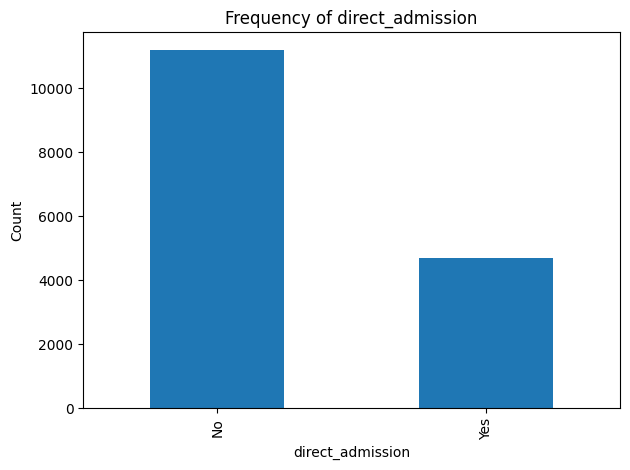

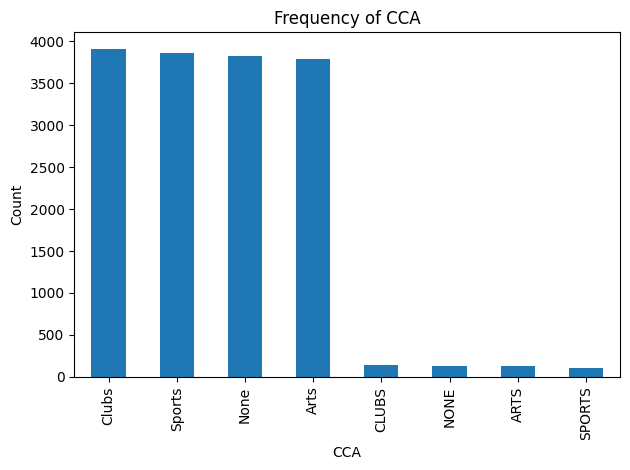

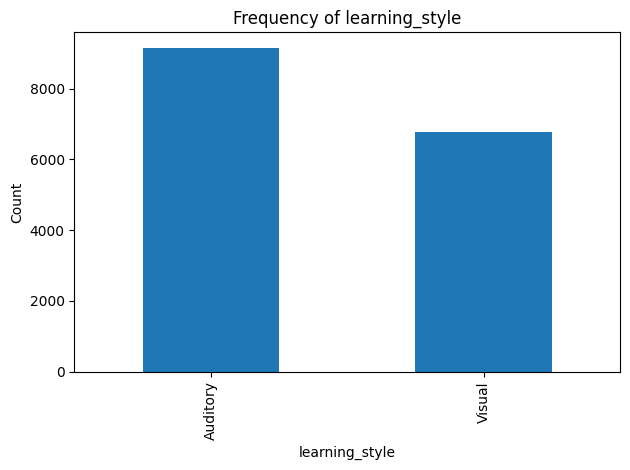

In [ ]:
# 1. Picking our working table (as before)
main_table = list(dataframes.keys())[0]
df = dataframes[main_table]
print(f"Categorical analysis on table: {main_table}")

# 2. Identifing categorical columns automatically
cat_cols = df.select_dtypes(include='object').columns.tolist()

# 3. Plot frequency bar chart for each categorical column
for col in cat_cols:
    fig, ax = plt.subplots()
    df[col].value_counts().plot(kind='bar', ax=ax)
    ax.set_title(f'Frequency of {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Count')
    plt.tight_layout()
    plt.show()

# Why: Understanding how text fields are distributed and how they relate to our target variable.

### **What the Categorical Analysis Shows**

##### **Frequency Charts** : direct_admission: ~11,000 “No” vs ~4,600 “Yes.”
##### **CCA**: Most students in “Clubs,” “Sports,” or “None,” with very few in uppercase variants (“CLUBS,” “NONE,” etc.)—suggests we can unify these labels.
##### **learning_style**: More “Auditory” (~9,000) than “Visual” (~7,000).
##### **gender**: Roughly equal M/F split.
##### **tuition**: More “Yes” than “No,” very few odd “Y” or “Z” entries—another candidate for label cleanup.
##### **sleep_time & wake_time**: Almost everyone sleeps between 21:00–23:00 and wakes 05:00–07:00.
##### **mode_of_transport**: Mostly “public transport” or “private transport,” with some walking.
##### **bag_color**: Even spread across the six colors.



In [ ]:
# 4. For numeric target ('final_test'), plot boxplots by category
numeric_cols = df.select_dtypes(include='number').columns.tolist()
if 'final_test' in numeric_cols:
    target = 'final_test'
else:
    # fallback: pick the first numeric column
    target = numeric_cols[0]

for col in cat_cols:
    fig, ax = plt.subplots()
    df.boxplot(column=target, by=col, ax=ax)
    ax.set_title(f'{target} by {col}')
    ax.set_xlabel(col)
    ax.set_ylabel(target)
    plt.suptitle('')  # remove the automatic suptitle
    plt.tight_layout()
    plt.show()


# Why: Understanding how text fields are distributed and how they relate to our target variable.


### **Boxplots of final_test by Category**

##### **direct_admission**: Median score is higher for “Yes” (around 75) than “No” (around 65). “Yes” group has more low outliers—worth investigating.
##### **CCA**: Students with no CCA (“None”) show the highest median (~75) and range.“Clubs” and “Sports” medians (~65) are slightly lower; “ARTS” around ~64. Again, uppercase variants split the same category— it can be combined them for clarity.
##### **learning_style**: Visual learners have a higher median (~73) than Auditory (~65) and a tighter range—suggests learning style may influence outcomes.
##### **Learning Style**: Visual learners have a noticeably higher median score (~73) and tighter spread than auditory learners (~65).
##### **Gender**: Male and female medians (~68) and spreads are virtually identical—no strong gender gap.
##### **Tuition**: Students with tuition (“Yes”/“Y”) score higher on average (median ~74) than those without (~62).
##### **Sleep Time**: Students sleeping after 21:00 tend to have higher medians (~70) vs. those sleeping before (~45–50), though early sleepers show more low outliers.
##### **Wake Time**: Little difference across waking hours (05:00–07:00), all medians around 67–68.
##### **Mode of Transport**: “Private transport,” “public transport,” and “walk” all cluster around the same median (~68), with similar spreads.
##### **Bag Color**: No meaningful difference in scores by bag color—all medians sit around ~68 with similar variability.
##### Overall, tuition, sleep patterns, and learning style appear to relate most to exam performance.

#### **Numeric Feature Correlations Heatmap**

In [ ]:
# 1. Dynamically select the main table and assign to df
main_table = list(dataframes.keys())[0]
df = dataframes[main_table]
print(f"Correlation analysis on table: {main_table}")

# 2. Select all numeric columns automatically (dropping a default index when present)
num_df = df.select_dtypes(include='number').copy()
if 'index' in num_df.columns and num_df['index'].equals(pd.Series(range(len(num_df)))):
    num_df = num_df.drop(columns=['index'])

# 3. Compute the correlation matrix
corr = num_df.corr()

# 4. Plot and annotate the heatmap

fig, ax = plt.subplots(figsize=(8,6))
cax = ax.imshow(corr, cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax, label='Correlation')

# Label axes with dynamic column names
cols = corr.columns
ax.set_xticks(ny.arange(len(cols)))
ax.set_yticks(ny.arange(len(cols)))
ax.set_xticklabels(cols, rotation=45, ha='right')
ax.set_yticklabels(cols)

# Annotate each cell with its correlation coefficient
for i in ny.arange(len(cols)):
    for j in ny.arange(len(cols)):
        ax.text(j, i, f"{corr.iat[i,j]:.2f}", ha='center', va='center')

plt.title(f'Numeric Feature Correlations — {main_table}')
plt.tight_layout()
plt.show()

# Why it’s dynamic:  
# Main table is chosen from the dataframes dict by variable, never hard‑coded.
# Numeric columns are selected by dtype, and any default index sequence is dropped automatically.
# Annotations and labels are driven by the actual column names in corr.

##### **Analysis**: Above heatmap shows the strength of correlations between features like "final_test" and "n_female", or "attendance_rate" and "hours_per_week". It provides insights into potential predictors for models or areas requiring further investigation.

In [ ]:
# flowchart TD
#     A[Start: Raw data in score.db] --> B[Step 0: Data Cleaning & Preprocessing]
#     B --> C[Step 1: Numeric & Categorical Correlation Heatmaps]
#     C --> D[Step 2: Scatter‑Plots for Key Pairs]
#     D --> E[Step 3: Feature Engineering]
#     E --> F[Step 4: Threshold‑Based Risk Flagging]
#     F --> G[Step 5: Define Score Cohorts (Low/Average vs High)]
#     G --> H[Step 6: Group‑Comparison Summaries]
#     H --> I[Step 7: Synthesize & Report Insights]
#     I --> J[End: Actionable Recommendations]

#     subgraph “0. Data Cleaning & Preprocessing”
#       B1[• Drop index & age outlier]  
#       B2[• Unify CCA, tuition, CCA labels]  
#       B3[• Impute or drop missing attendance_rate]  
#       B4[• Parse sleep_time/wake_time → numeric hour]  
#       B5[• Drop bag_color (no signal)]
#     end

#     subgraph “1. Correlation Heatmaps”
#       C1[• Numeric: Pearson]  
#       C2[• Categorical: Cramér’s V/Theil’s U]
#     end

#     subgraph “2. Scatter‑Plots”
#       D1[• attendance_rate vs final_test]  
#       D2[• hours_per_week vs final_test]  
#       D3[• sleep_hour vs final_test]
#     end

#     subgraph “3. Feature Engineering”
#       E1[• Binarize direct_admission & tuition]  
#       E2[• One‑hot encode learning_style, CCA]  
#       E3[• Derive “total_siblings” from n_male & n_female]
#     end

#     subgraph “4. Risk Flagging”
#       F1[• Compute score percentiles (<20%, <10%)]  
#       F2[• Tag “at_risk” & “needs_support”]
#     end

#     subgraph “5. Define Cohorts”
#       G1[• Low/Average: final_test ≤ cutoff]  
#       G2[• High: final_test > cutoff]
#     end

#     subgraph “6. Group Comparisons”
#       H1[• Compare siblings, sleep, attendance, CCA, etc.]  
#       H2[• Boxplots & summary tables for each cohort]
#     end

#     subgraph “7. Synthesize Insights”
#       I1[• Merge findings into a single report]  
#       I2[• Highlight patterns & actionable takeaways]
#     end


#### **Categorical Feature Correlations (Cramér's V)**

In [ ]:
# 1. Pick your categorical columns exactly as in score.db
cat_cols = [
    'direct_admission', 'CCA', 'learning_style',
    'gender', 'tuition', 'mode_of_transport'
]

# 2. Cramér’s V function for categorical pairs
def cramers_v(x, y):
    tbl = pd.crosstab(x, y)
    chi2, _, _, _ = chi2_contingency(tbl)
    n = tbl.values.sum()
    phi2 = chi2 / n
    r, k = tbl.shape
    return ny.sqrt(phi2 / min(k-1, r-1))

# 3. Build the matrix
cv = pd.DataFrame(index=cat_cols, columns=cat_cols, dtype=float)
for c1 in cat_cols:
    for c2 in cat_cols:
        cv.loc[c1, c2] = cramers_v(df[c1], df[c2])

# 4. Plot
plt.figure(figsize=(7,6))
sns.heatmap(cv.astype(float), annot=True, cmap='coolwarm', vmin=0, vmax=1)
plt.title("Categorical Correlations (Cramér’s V)")
plt.tight_layout()
plt.show()

# Why: D was chosen because it measures the strength of association between two categorical variables.
# It calculates the relationship using the chi-square statistic, normalized to a scale from 0 (no association) to 1 (strong association), considering the size of the contingency table.
# It computes the correlation matrix for categorical columns in the dataset and visualizes the relationships using a heatmap.

##### **Brief Interpretation of Categorical heatmap**: The Cramér's V values are quite low (ranging from 0.00 to 0.13), which suggests that there is little to no significant relationship between the categorical features. Features like "CCA", "tuition", "learning_style", etc., do not show strong associations with each other.

#### **Scatter‑Plots to Spot Cut‑Off Regions**

In [ ]:
# 1. Parse sleep & wake times robustly
df['sleep_hour'] = pd.to_datetime(df['sleep_time'], errors='coerce').dt.hour
df['wake_hour'] = pd.to_datetime(df['wake_time'], errors='coerce').dt.hour

# 2. Fill missing values in categorical columns
cat_cols = ['direct_admission', 'CCA', 'learning_style', 'gender', 'tuition', 'mode_of_transport']
for col in cat_cols:
    df[col] = df[col].fillna('Missing')

# 3. Cramér's V function for categorical pairs
def cramers_v(x, y):
    tbl = pd.crosstab(x, y)
    if tbl.size == 0 or tbl.values.sum() == 0:
        return ny.nan
    chi2, _, _, _ = chi2_contingency(tbl, correction=False)
    n = tbl.values.sum()
    phi2 = chi2 / n
    r, k = tbl.shape
    return ny.sqrt(phi2 / max(1, min(k-1, r-1)))

# 4. Scatter-Plots for Key Pairs without repeating previous heatmap code
pairs = [
    ('attendance_rate', 'final_test'),
    ('hours_per_week', 'final_test'),
    ('number_of_siblings', 'final_test'),
    ('sleep_hour', 'final_test')
]

# Generate scatter plots for key pairs
for x, y in pairs:
    plt.figure(figsize=(5, 4))
    sns.scatterplot(data=df, x=x, y=y, alpha=0.5)
    plt.xlabel(x.replace('_', ' ').title())
    plt.ylabel(y.replace('_', ' ').title())
    plt.title(f"{y.replace('_', ' ').title()} vs {x.replace('_', ' ').title()}")
    plt.tight_layout()
    plt.show()

# The purpose of the scatter plots is to visually examine the relationships between final_test scores and other key variables (like attendance_rate, hours_per_week, etc.) to uncover patterns or trends.


### **Analysis of the Output**
#### **Attendance Rate vs Final Test**: There is a strong concentration of data points at 90-100% attendance, with very few students scoring below 60% final test scores. This suggests attendance could be a key factor for achieving high scores.
#### **Hours per Week vs Final Test**: The data shows a varied range of hours per week spent on study, but the final test scores do not show a clear trend, indicating that hours spent studying may not directly correlate with final scores.
#### **Number of Siblings vs Final Test**: There is no clear relationship between the number of siblings and final test scores, as the data is clustered with a few distinct groups.
#### **Sleep Hour vs Final Test**: The scatter plot is almost empty, suggesting no significant relationship between the sleep hour variable and final test scores.

#### **Threshold‑Based Risk Flagging**

In [ ]:
# Purpose: This code was chosen to identify students with lower performance who might need additional attention, based on their final test scores.

# Mark the bottom 20% of final_test scores as “at_risk”
threshold_20 = df['final_test'].quantile(0.20)
df['at_risk'] = (df['final_test'] <= threshold_20).astype(int)

# Quick check: how many flagged?
counts = df['at_risk'].value_counts().rename({0:'OK',1:'At_Risk'})
print(counts)


##### **Interpretation**: The code flags the bottom 20% of final test scores as "at risk" and counts how many students fall under this category.

#### **Define Low/Average vs High Cohorts**

In [ ]:
# Purpose: The purpose of this code is to categorize students into meaningful groups based on performance, to facilitate further comparisons between these cohorts.

# Split at the median into two cohorts
median_score = df['final_test'].median()
df['cohort'] = ny.where(df['final_test'] > median_score, 'High', 'Low/Average')

print(df['cohort'].value_counts())


##### **Interpretation**: The code splits students into two groups: Low/Average and High, based on the median final test score, and counts how many students fall into each group.



#### **Group‑Comparison Summaries**

In [ ]:
# Purpose: This code helps to compare characteristics of students in different performance groups, providing insights into potential factors that differentiate them.

# Compare key features across cohorts
features = [
    'number_of_siblings', 'sleep_hour',
    'attendance_rate',   'hours_per_week'
]

group_stats = df.groupby('cohort')[features].agg(['mean','median','std','count'])
print(group_stats)


##### **Interpretation**: The code compares key features (like attendance, siblings, hours per week, etc.) across the Low/Average and High cohorts, showing mean, median, and standard deviation for each feature.